In [1]:
# Mount drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
import sys, importlib
# import utility

env = 'dev'

# DWM project - Explorative Data Analysis

The aim of this notebook is to 
- understand the data structure 
- understand all possible issues on the data that can compromise the model creation phase
- try to solve the aforementioned issues

In order to make this analysis as clear and self-explanatory as possible, I'll try to use many graphical representations.
Many ideas on graphs are taken from the professor classes, kaggle competitions and from the internet, especially from Towards Data Science and implemented with the help of my best friend, Stack Overflow.

### Let's start by importing the data
I put all properties data into a dataframe and all transaction data into another.
The analysis is done on all properties and all transactions, because
1. it's more data in which make statistics (and we know that more data implies better statistics)
2. I see no reason to take them independently, they are just homes, and because of the short temporal span I assume that they don't change their features.

Due to the lack of powerful hardware to make the computation, I decided to take only a part of the whole dataset, that is 100k house properties out of almost 3M for both `properties_2016` and `properties_2017`. This was decided after having found that the time for even easy computation was too long.
This of course came at the cost of considerations and models that can be not as good as the ones created with the whole dataset; however the process is the same.

In [3]:
# Read data
n = 100000
properties_2016 = pd.read_csv("../DWMProjectData/properties_2016.csv", nrows = n)
properties_2017 = pd.read_csv("../DWMProjectData/properties_2017.csv", nrows = n)
transactions_2016 = pd.read_csv("../DWMProjectData/train_2016_v2.csv")
transactions_2017 = pd.read_csv("../DWMProjectData/train_2017.csv")

C:\Users\marco\anaconda3\envs\DWMProject\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


A warning is raised due to some columns of type object and with NaN value: I'll handle this later.

In [4]:
# Merge the properties datasets
properties = pd.concat([properties_2016, properties_2017], axis=0) # TODO occhio a istanze ripetute
transactions =  pd.concat([properties_2016, properties_2017], axis=0)

In [5]:
# Delete datasets that I'll not use (I need a lot of memory)
del properties_2016, properties_2017, transactions_2016, transactions_2017

## Explorative analysis of `properties` dataset

### Dataset exploration

I can already imagine a problem: some houses are repeated on the dataset of 2016 and 2017. In order to save memory, it's a good idea to keep only one house if they are exacly the same.

In [6]:
# Drop duplicates on concatenated property dataset
print(f"#Properties rows before duplicate removal: {properties.shape[0]}")
properties.drop_duplicates(keep='first',inplace=True)
print(f"#Properties rows after duplicate removal: {properties.shape[0]}")
print(f"Properties has {properties.duplicated(subset=['parcelid'], keep=False).sum()} houses repeated with differents attributes [{round(properties.duplicated(subset=['parcelid'], keep=False).sum() * 100 / properties.shape[0] ,2)}% of data]")

#Properties rows before duplicate removal: 200000
#Properties rows after duplicate removal: 199879
Properties has 199020 houses repeated with differents attributes [99.57% of data]


It seems that many houses are repeated, but with different values in some columns. Let's have a look on some record in order to have a more clear idea on what's happening:

In [7]:
properties[properties.duplicated(subset=['parcelid'], keep=False)].sort_values(by='parcelid').iloc[0:10]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
58104,10711745,1.0,NaN,NaN,3.0,4.0,NaN,4.0,3.0,NaN,...,NaN,NaN,237085.0,457619.0,2015,220534.0,5863.18,NaN,NaN,6.037113e+13
58273,10711745,1.0,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,240700.0,464597.0,2016,223897.0,5863.18,NaN,NaN,6.037113e+13
43294,10711767,NaN,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,181354.0,373108.0,2016,191754.0,4642.73,NaN,NaN,6.037113e+13
43167,10711767,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,NaN,...,NaN,NaN,178630.0,367504.0,2015,188874.0,4642.73,NaN,NaN,6.037113e+13
28470,10711789,NaN,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,147018.0,296477.0,2016,149459.0,3798.51,NaN,NaN,6.037113e+13
28385,10711789,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,NaN,...,NaN,NaN,144810.0,292024.0,2015,147214.0,3798.51,NaN,NaN,6.037113e+13
73149,10711869,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,NaN,...,NaN,NaN,126744.0,452425.0,2016,325681.0,5659.19,NaN,NaN,6.037113e+13
72945,10711869,NaN,NaN,NaN,2.0,4.0,NaN,4.0,2.0,NaN,...,NaN,NaN,124841.0,445630.0,2015,320789.0,5659.19,NaN,NaN,6.037113e+13
58274,10711891,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,NaN,...,NaN,NaN,145666.0,299292.0,2016,153626.0,3743.10,NaN,NaN,6.037113e+13
58105,10711891,1.0,NaN,NaN,2.0,4.0,NaN,4.0,2.0,NaN,...,NaN,NaN,143478.0,294797.0,2015,151319.0,3743.10,NaN,NaN,6.037113e+13


We can notice that many houses are duplicated; some houses are exactly the same over 2016 and 2017 and other has changed. Taking a brief look at the data, the changes mainly involve columns like `structuretaxdollarcnt`, `taxvaluedollarcnt` and `landtaxvaluedollarcnt`, that is normal that change over the years.
I came at the conclusion that this duplicated but slightly different rows can be both removed and keep, for different reasons:
- it's a good idea to remove them because you basically have half the data to manage, but at the same time
- it's a good idea to keep them in order to have a better prediction over different years

I go for the second option, since the aim of the project is give predictions for different time periods.

### Data type exploration

First I print all the types of the columns to make sure there is no unusual or strange type to deal with

In [8]:
for col in properties.columns:
    print(f"{properties.columns.get_loc(col)} | {col}: {properties[col].dtype}")

0 | parcelid: int64
1 | airconditioningtypeid: float64
2 | architecturalstyletypeid: float64
3 | basementsqft: float64
4 | bathroomcnt: float64
5 | bedroomcnt: float64
6 | buildingclasstypeid: float64
7 | buildingqualitytypeid: float64
8 | calculatedbathnbr: float64
9 | decktypeid: float64
10 | finishedfloor1squarefeet: float64
11 | calculatedfinishedsquarefeet: float64
12 | finishedsquarefeet12: float64
13 | finishedsquarefeet13: float64
14 | finishedsquarefeet15: float64
15 | finishedsquarefeet50: float64
16 | finishedsquarefeet6: float64
17 | fips: int64
18 | fireplacecnt: float64
19 | fullbathcnt: float64
20 | garagecarcnt: float64
21 | garagetotalsqft: float64
22 | hashottuborspa: object
23 | heatingorsystemtypeid: float64
24 | latitude: int64
25 | longitude: int64
26 | lotsizesquarefeet: float64
27 | poolcnt: float64
28 | poolsizesum: float64
29 | pooltypeid10: float64
30 | pooltypeid2: float64
31 | pooltypeid7: float64
32 | propertycountylandusecode: object
33 | propertylanduset

Types are int64, float64 and object
I think it's a good idea to switch from int64 to int32 and from float64 to float32, since the ensure enough precision for the task we are required to perform.

In [9]:
from sys import getsizeof

print(f"size of properties before: {round(getsizeof(properties)/1000000, 2)} MB")
for col in properties.columns:
    if properties[col].dtype == 'int64':
        print(f"convert {col} form int64 to int32")
        properties[col] = properties[col].astype('int32')
    elif properties[col].dtype == 'float64':
        print(f"convert {col} form float64 to float32")
        properties[col] = properties[col].astype('float32')
    else:
        print(f"skip {col}")
print(f"size of properties after: {round(getsizeof(properties)/1000000, 2)} MB")

size of properties before: 128.36 MB
convert parcelid form int64 to int32
convert airconditioningtypeid form float64 to float32
convert architecturalstyletypeid form float64 to float32
convert basementsqft form float64 to float32
convert bathroomcnt form float64 to float32
convert bedroomcnt form float64 to float32
convert buildingclasstypeid form float64 to float32
convert buildingqualitytypeid form float64 to float32
convert calculatedbathnbr form float64 to float32
convert decktypeid form float64 to float32
convert finishedfloor1squarefeet form float64 to float32
convert calculatedfinishedsquarefeet form float64 to float32
convert finishedsquarefeet12 form float64 to float32
convert finishedsquarefeet13 form float64 to float32
convert finishedsquarefeet15 form float64 to float32
convert finishedsquarefeet50 form float64 to float32
convert finishedsquarefeet6 form float64 to float32
convert fips form int64 to int32
convert fireplacecnt form float64 to float32
convert fullbathcnt form

The saved space is significant, so maybe I can use this space to upload more data in order to have better models.

### Charts & visualization

#### Visualization of columns that has one unique value
Since they don't provide any useful information, they should be removed

In [10]:
useless_cols = []
for col in properties.columns:
    if properties[col].nunique(dropna=False) == 1:
        useless_cols.append(col)
print(f"useless columns: {useless_cols} ({len(useless_cols)})")

useless columns: [] (0)


It seems that every columns contains at least 2 different values, although one of them can be NaN. We'll handle that later.

#### Visualization of missing values
Let's visualize the percentual of missing values for each column. To avoid to print all column, let's set a threshold

In [11]:
from texttable import Texttable
threshold = 0.90
t = Texttable()
t.add_rows([['Column', '% missing values']])
for col in properties.columns:
    current_threshold = properties[col].isna().sum()/properties.shape[0]
    if current_threshold > threshold:
        t.add_row([col, f'{round(current_threshold*100,2)}%'])
print(t.draw())

+--------------------------+------------------+
|          Column          | % missing values |
+==========================+==================+
| architecturalstyletypeid | 99.82%           |
+--------------------------+------------------+
| basementsqft             | 99.95%           |
+--------------------------+------------------+
| buildingclasstypeid      | 99.56%           |
+--------------------------+------------------+
| decktypeid               | 99.41%           |
+--------------------------+------------------+
| finishedfloor1squarefeet | 93.0%            |
+--------------------------+------------------+
| finishedsquarefeet13     | 99.72%           |
+--------------------------+------------------+
| finishedsquarefeet15     | 93.44%           |
+--------------------------+------------------+
| finishedsquarefeet50     | 93.0%            |
+--------------------------+------------------+
| finishedsquarefeet6      | 99.31%           |
+--------------------------+------------

I think it can be a good idea to remove some column that have really few data and for which I have no good idea on how to fill the NaN with intelligent values.
I remove `architecturalstyletypeid`, `basementsqft`, `buildingclasstypeid`, `decktypeid`, `storytypeid`,`yardbuildingsqft17`, `yardbuildingsqft26`, `taxdelinquencyflag`, `taxdelinquencyyear`.
I keep the other because they can be useful. For some columns will be trivial to fill the NaN (for example, for pools, NaN will become 0), for others such as finishedfloor, it'll be harder.

In [12]:
to_drop = ['architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'storytypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'taxdelinquencyflag', 'taxdelinquencyyear']
properties.drop(columns=to_drop, inplace=True)
print(f"properties shape: {properties.shape}")

properties shape: (199879, 49)


#### Charts on correlation
Let's visualize the correlation between columns through a heatmap

<AxesSubplot:>

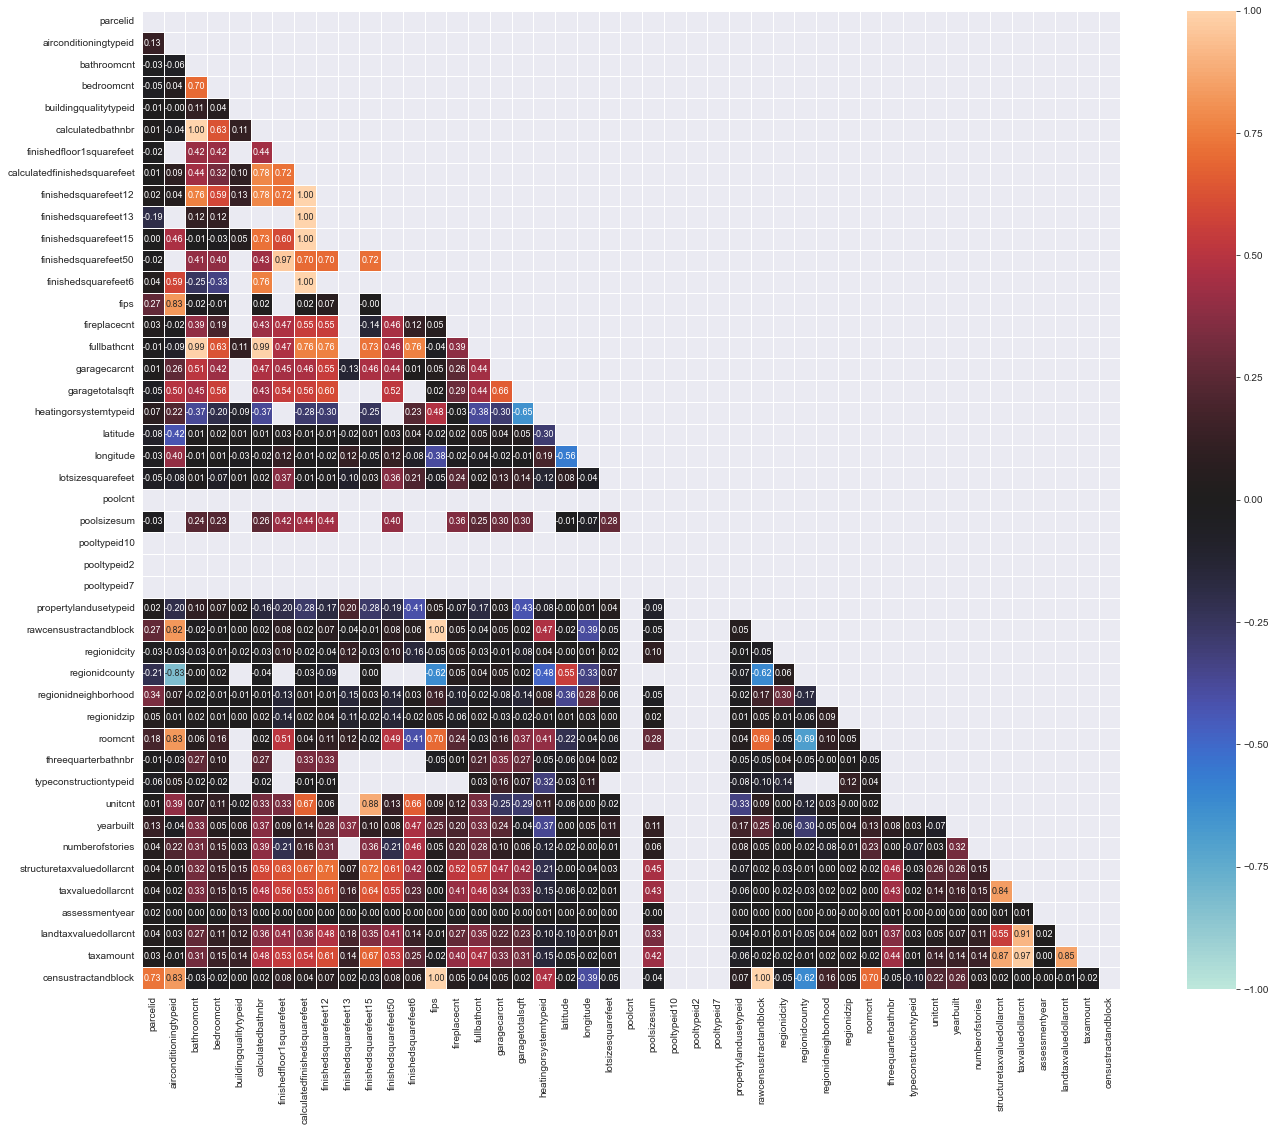

In [13]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = properties.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.close("all")
f, ax = plt.subplots(figsize=(24, 18))

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, vmax=1.0, vmin=-1.0, center=0, square=True, annot=True, fmt=".2f", annot_kws={"size":9}, linewidths=.5)

We can immedialy note that for some columns it's no possible to compute the correlation: let's dive into them to understand why

In [14]:
col_to_examine = ['poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7']
for col in col_to_examine:
    print(f"{col.upper()}: \n{properties[col].describe()} \n%NaN:{round(properties[col].isna().sum()*100/properties.shape[0], 2)}")

POOLCNT: 
count    35520.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: poolcnt, dtype: float64 
%NaN:82.23
POOLTYPEID10: 
count    1655.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: pooltypeid10, dtype: float64 
%NaN:99.17
POOLTYPEID2: 
count    2004.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: pooltypeid2, dtype: float64 
%NaN:99.0
POOLTYPEID7: 
count    33487.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: pooltypeid7, dtype: float64 
%NaN:83.25


The common characteristics between this columns is that are columns with unique value + NaN.
I'll handle them later.

We note also from the heatmap that some columns seems to be highly correlated: I'll set a threshold and I'll leave on the dataset only one column between each correlated group, and I choose to keep the column with less NaN.
This is a process that can't be automated too much because someone (myself) need to understand the groups of correlated variables (based on columns names)

In [15]:
from texttable import Texttable

t=Texttable()
t.add_rows([["row", "column", "correlation"]])
threshold = 0.9

for r in corr.columns:
    for c in corr.columns:
        if corr.loc[r,c] > 0.9 and corr.columns.get_loc(r) > corr.columns.get_loc(c): # check also to take only values under the main diagonal (to avoid repetitions)
            t.add_row([r,c,corr.loc[r,c]])

print(t.draw())

+------------------------+------------------------------+-------------+
|          row           |            column            | correlation |
+========================+==============================+=============+
| calculatedbathnbr      | bathroomcnt                  | 1           |
+------------------------+------------------------------+-------------+
| finishedsquarefeet12   | calculatedfinishedsquarefeet | 1           |
+------------------------+------------------------------+-------------+
| finishedsquarefeet13   | calculatedfinishedsquarefeet | 1           |
+------------------------+------------------------------+-------------+
| finishedsquarefeet15   | calculatedfinishedsquarefeet | 1           |
+------------------------+------------------------------+-------------+
| finishedsquarefeet50   | finishedfloor1squarefeet     | 0.968       |
+------------------------+------------------------------+-------------+
| finishedsquarefeet6    | calculatedfinishedsquarefeet | 1     

So the groups can be:
- calculatedbathnbr, bathroomcnt, fullbathcnt
- finishedsquarefeet12, finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, calculatedfinishedsquarefeet
- rawcensustractandblock, fips, censustractandblock
- landtaxvaluedollarcnt, taxvaluedollarcnt, taxamount

For each of them, I'll take the one with more non-NaN value and keep only it

In [16]:
groups = [['calculatedbathnbr', 'bathroomcnt', 'fullbathcnt'],
          ['finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'calculatedfinishedsquarefeet'],
          ['rawcensustractandblock', 'fips', 'censustractandblock'],
          ['landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount']]

for g in groups:
    min_nan = properties.shape[0]
    to_keep = ""
    # print(f"GROUP {g}")
    for el in g:
        # print(f"{el}: {properties[el].isna().sum()} nan")
        if properties[el].isna().sum() < min_nan:
            min_nan = properties[el].isna().sum()
            to_keep = el
    g.remove(to_keep)
    # print(f"REMOVE: {g}\n")

    properties.drop(columns=g, inplace=True)

print(f"properties shape: {properties.shape}")

properties shape: (199879, 39)


#### Charts on variable distributions for non-categorical columns
Let's visualize the distribution of each column, in order to understand how data is distributed and if there are outliers through a boxplot

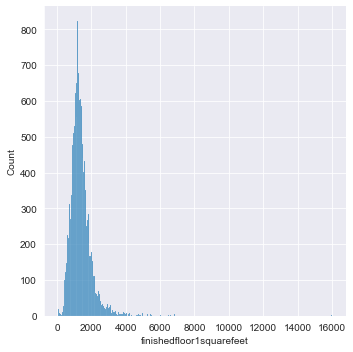

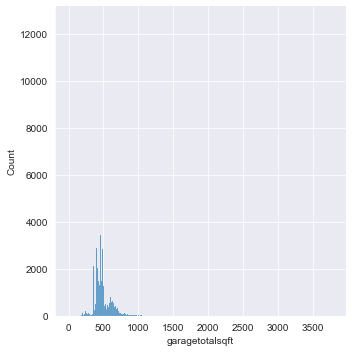

In [25]:
from matplotlib import pyplot as plt
import seaborn as sb

sb.displot(properties["finishedfloor1squarefeet"])
sb.displot(properties["garagetotalsqft"])



In [22]:
properties.columns

Index(['parcelid', 'airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet6', 'fireplacecnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'yearbuilt',
       'numberofstories', 'fireplaceflag', 'structuretaxvaluedollarcnt',
       'assessmentyear', 'taxamount'],
      dtype='object')

#### Charts of #levels for categorical columns
For categorical columns, let's visualize the number of levels, in order to have an idea if it's feasible to perform one-hot-encoding

In [246]:
# grafico con sulle x le colonne e sulle y i livelli
categorical_features = []


### Other analysis
Still something can be made, for example looking at variable names that seems similar: does they mean the same thing?

What about objects?

### NaN handle

## Explorative analysis of `transactions` dataset

## Joining datasets and exporting data to create models

Joino i dataset e li esporto tipo in .csv al fine di avere i dati pronti per la creazione dei modelli





Useful resources:
- https://stackoverflow.com/questions/15819050/pandas-dataframe-concat-vs-append
